In [1]:
import torch
import numpy as np
from os import walk
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, accuracy_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
# dataset is here: smb://nas-weber01.unisg.ch/data/Nassy/03_Online_Model/features
_, _, file_names = next(walk('./dataset'))

files = [(name.split('_')[0], name.split('_')[1].split('.')[0], name) for name in file_names]

dataset = pd.DataFrame()

for (subject_number, task, file_name) in files:
    part = pd.read_csv(f'./dataset/{file_name}')
    labels = pd.read_csv(f'./labels/{subject_number}.csv', sep=";").set_index('task')
    rating = float(labels.loc[task]['r'])
    part['label'] = int(rating > 4)
    part['subject'] = subject_number
    part['d_lhipa'] = part['e_lhipa'] - part['b_lhipa']
    part['d_peak_count'] = part['e_peak_count'] - part['b_peak_count']
    part['d_median'] = part['e_median'] - part['b_median']
    part['d_std'] = part['e_std'] - part['b_std']
    part['d_mean'] = part['e_mean'] - part['b_mean']
    part['d_min'] = part['e_min'] - part['b_min']
    part['d_max'] = part['e_max'] - part['b_max']

    dataset = pd.concat([part, dataset])

print(len(dataset[dataset['label'] == 1]), len(dataset[dataset['label'] == 0]))
    
dataset.tail(10)

16 48


,task,subject,d_mean,d_median,d_std,e_min,e_max,e_mean,e_median,e_std,e_peak_count,e_peak_count_pm,b_min,b_max,b_mean,b_median,b_std,b_peak_count,b_peak_count_pm,e_lhipa,b_lhipa,label,d_lhipa,d_peak_count,d_min,d_max
0,t4,006,-0.569478,-0.579536,-0.058207,2.430351,3.622368,2.821069,2.803734,0.137368,0,0.000000,2.745506,4.209579,3.390547,3.383270,0.195575,5,2.479339,14.9,15.3,0,-0.4,-5,-0.315155,-0.587212
0,t6,004,-0.429937,-0.492527,0.003872,1.797821,4.200607,2.633973,2.588467,0.289315,1,0.262009,1.964958,4.061157,3.063911,3.080994,0.285443,1,0.500000,5.8,9.3,0,-3.5,0,-0.167137,0.139450
0,t2,007,-0.886280,-0.914997,-0.074992,2.660255,4.317909,3.224681,3.213215,0.162437,7,1.590909,2.962059,5.174789,4.110960,4.128212,0.237429,15,7.438017,16.9,15.5,0,1.4,-8,-0.301804,-0.856880
0,t4,001,-0.681159,-0.798630,-0.290822,3.194458,4.603775,3.733329,3.702309,0.205717,0,0.000000,2.736359,5.277191,4.414489,4.500938,0.496539,0,0.000000,11.1,0.0,0,11.1,0,0.458099,-0.673416
0,t1,006,-0.469682,-0.442619,-0.138452,2.455009,3.858673,2.912484,2.911594,0.117230,2,1.111111,2.599892,4.456154,3.382166,3.354214,0.255682,17,8.429752,13.7,16.0,0,-2.3,-15,-0.144882,-0.597481
0,t5,005,-1.182537,-1.194626,-0.088568,2.549667,4.754761,3.235325,3.219749,0.204202,5,2.678571,3.232468,5.283768,4.417862,4.414375,0.292770,9,4.500000,16.2,16.3,0,-0.1,-4,-0.682800,-0.529007
0,t2,002,-0.545537,-0.583557,-0.106694,2.818504,4.032967,3.313507,3.298882,0.189688,30,11.612903,2.775818,4.772858,3.859044,3.882439,0.296381,10,5.000000,20.4,14.3,1,6.1,20,0.042686,-0.739891
0,t4,002,-0.769384,-0.734402,-0.193471,2.576424,3.654205,3.128884,3.118023,0.156083,6,8.000000,3.195885,4.839569,3.898267,3.852425,0.349554,2,1.000000,11.5,15.6,0,-4.1,4,-0.619461,-1.185364
0,t6,002,-0.723869,-0.704559,-0.135302,2.464912,3.819771,3.256605,3.257637,0.173136,25,7.211538,3.122124,4.824509,3.980474,3.962196,0.308438,4,1.983471,23.4,14.6,1,8.8,21,-0.657211,-1.004738
0,t1,005,-0.771427,-0.839497,-0.150646,2.962013,4.357460,3.545971,3.523121,0.178918,2,5.217391,2.743759,5.345238,4.317399,4.362617,0.329564,49,24.500000,7.0,16.5,0,-9.5,-47,0.218254,-0.987778


In [4]:
## create model
class NN(torch.nn.Module):
    def __init__(self, input_dimension,number_of_target_classes):
        super().__init__()
        # stack layers
        self.module_list = torch.nn.ModuleList()
        ## stacks contain of linear + nonlinear layers
        self.module_list.append(torch.nn.Linear(input_dimension,200))
        self.module_list.append(torch.nn.Tanh())
        #
        self.module_list.append(torch.nn.Linear(200,200))
        self.module_list.append(torch.nn.Tanh())
        #
        self.module_list.append(torch.nn.Linear(200,150))
        self.module_list.append(torch.nn.Tanh())
        # map to output layer
        self.module_list.append(torch.nn.Linear(150,number_of_target_classes))
    
    def forward(self,x):
        for module in self.module_list:
            x = module(x)
        return x

def train(dataset, task=None, subject=None):
    if not task:
        TRAIN_FILTER = (~(dataset['subject'] == subject))
    elif not subject:
        TRAIN_FILTER = (~(dataset['task'] == task))
    else:
        TRAIN_FILTER = (~(dataset['task'] == task) & ~(dataset['subject'] == subject))

    fields = ['d_mean', 'd_median', 'd_std', 'd_lhipa', 'd_max', 'd_min']
    data_train = dataset[~TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1)[fields].to_numpy()
    data_test = dataset[TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1)[fields].to_numpy()

    targets_train = dataset[~TRAIN_FILTER]['label'].to_numpy()
    targets_test = dataset[TRAIN_FILTER]['label'].to_numpy()


    ## wrap data in dataset
    # cast to tensor
    data_train = torch.tensor(data_train).float()
    targets_train = torch.tensor(targets_train).long()#.unsqueeze(dim=-1)
    data_test = torch.tensor(data_test).float()
    targets_test = torch.tensor(targets_test).long()#.unsqueeze(dim=-1)
    # wrap in dataset class
    dataset_train = torch.utils.data.TensorDataset(data_train, targets_train)
    dataset_test = torch.utils.data.TensorDataset(data_test, targets_test)
    # create dataloaders
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10,shuffle=True)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=10,shuffle=True)

    #instanciate model
    model = NN(len(fields),2)
    #model.to(device)
    # test forward pass
    model(data_train[:10])

    # def criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.001)

    # train
    for epoch in range(200):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs.to(device)
            targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # 
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 0:    # print every 50 mini-batches
                #print("Training loss {} Steps: {}".format(running_loss / 1000, epoch * len(trainloader) + i))
                running_loss = 0.0

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in testloader:
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('LOW', 'HIGH')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    
    return (cf_matrix, y_pred, y_true)

new tasks
accuracy 0.7232142857142857
precision 0.7004555911809685
recall 0.7232142857142857
new subjects
accuracy 0.6294642857142857
precision 0.6742677386407069
recall 0.6294642857142857
new_tasks_new_subjects
accuracy 0.6817602040816326
precision 0.6898474901450297
recall 0.6817602040816326


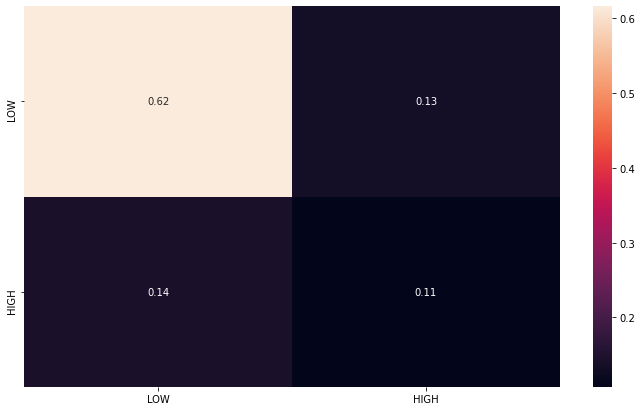

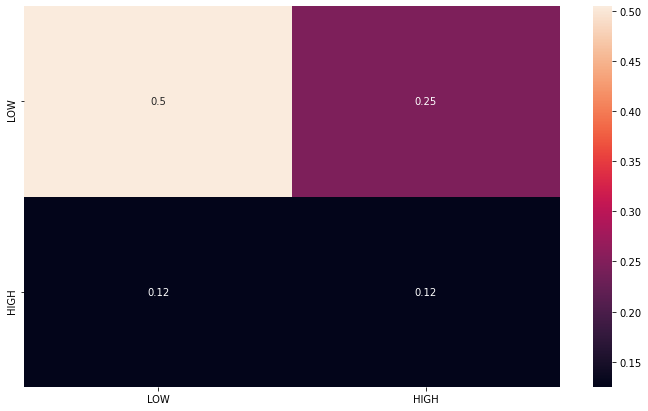

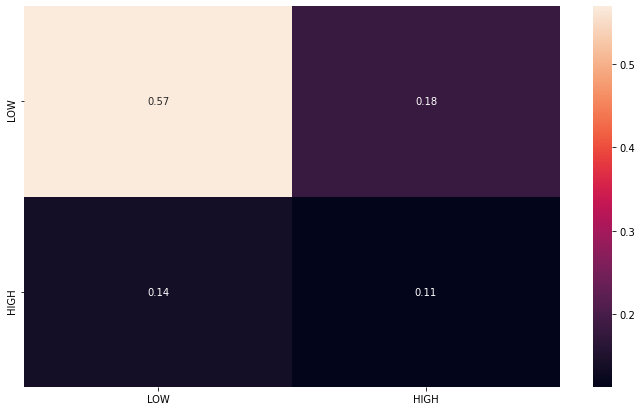

In [6]:
subjects = list(set([subject_number for (subject_number, task, file_name) in files]))
tasks = list(set([task for (subject_number, task, file_name) in files])) 

# train will run the training multiple times with given permutations as training data
new_tasks = list(itertools.product(tasks, [None]))
new_subjects = list(itertools.product([None], subjects))
new_tasks_new_subjects = list(itertools.product(tasks, subjects))

for name, permutation in [("new_tasks", new_tasks), ("new_subjects", new_subjects), ("new_tasks_new_subjects", new_tasks_new_subjects)]:
    print(name)
    results = []
    ys = []
    for task, subject in permutation:
        if task or subject:
            cf_matrix, y_pred, y_true = train(dataset=dataset, task=task, subject=subject)
            results.append(cf_matrix)
            ys.append([y_pred, y_true])


    print("accuracy", np.mean([accuracy_score(y_true, y_pred) for y_pred, y_true in ys]))
    print("precision", np.mean([precision_score(y_true, y_pred, average='weighted') for y_pred, y_true in ys]))
    print("recall", np.mean([recall_score(y_true, y_pred, average='weighted') for y_pred, y_true in ys]))
    confusion_matrices = np.mean(results, axis=(0))
    classes = ('LOW', 'HIGH')
    df_cm = pd.DataFrame(confusion_matrices/np.sum(confusion_matrices), index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    print("================================================")